# Cтатистический анализ данных

    Необходимо провести анализ популярного сервиса аренды самокатов GoFast. Есть данные о некоторых пользователях из нескольких городов, а также об их поездках и оформленных подписках. Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
    Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.
    Предоставлены три датафрейма:
    Пользователи — users_go.csv
    Поездки — rides_go.csv
    Подписки — subscriptions_go.csv

**План работы**
1. Предобработка данных (проверка пропусков,изменение типа данных)
2. Исследование и визуализация данных о пользователях и поездках
3. Обединение данных в один дата фрейм
4. Подсчет выручки
5. Проверка гипотез
6. Распределения


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import sqrt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

Выведем информацию о каждом датафрейме и выведем первые строки каждого набора данных

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


    Даны три датафрейма в первом  данные о пользователях (идентификатор пользователя, имя, город, возраст и тип подписки), во втором данные о поездах (идентификатор пользователя, время, расстояние и дата поездки), третий состоит всего из жвух строк - это варианты подписки. В первом есть столбцы которые встречаются во втором и тертьем датафрейме. Проверим перые два датафрейма на пропуски и дубликаты данных.


#### Шаг 2. Предобработка данных

##### Изменение столбца  к типу даты

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создание нового столбца с номером месяца

In [9]:
rides['ride_month'] = rides['date'].dt.month
rides.head(10)

,user_id,distance,duration,date,ride_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


##### Проверка пропущенных значений и дубликатов

In [10]:
#проверка на пустые значение, третий датафрейм можно не проверять, там всего две строки и они заполнены
print(users.isna().sum())
rides.isna().sum()


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


user_id       0
distance      0
duration      0
date          0
ride_month    0
dtype: int64

In [11]:
#проверка на дубликаты
print(users.duplicated().sum())
rides.duplicated().sum()


31


0

In [12]:
users = users.drop_duplicates().reset_index(drop=True) #удалим обнаруженные дубликаты
users.duplicated().sum()

0

В заданных датафреймах не обнаружили пустые значения, но было 31 строка с дубликатами, удалили их

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [13]:
users.groupby('city')['user_id'].agg(['count'])\
    .sort_values(by = 'count', ascending = False) # отсортируем данные по количеству пользователей в разрезе городов

,count
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Text(0.5, 1.0, 'Распределение по городам')

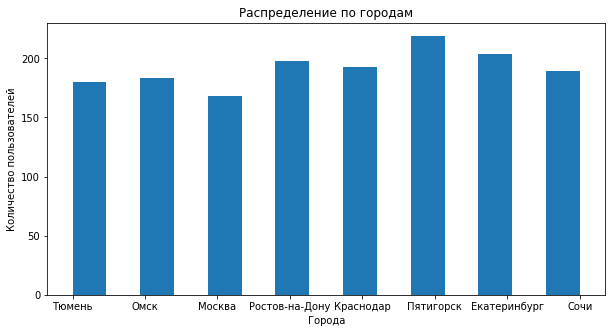

In [14]:
plt.figure(figsize=(10,5))
plt.hist(users['city'], bins=15)
plt.xlabel('Города')
plt.ylabel('Количество пользователей')
plt.title('Распределение по городам')

Частота встречаемости городов распределена практически равномерно. Больше всего пользователей самокатов в Пятигорске.

##### Соотношение пользователей с подпиской и без

In [15]:
users_type = users.groupby('subscription_type')['user_id'].agg(['count'])
users_type = users_type.reset_index()
users_type.columns=['subscription_type', 'count_subscription']
users_type

,subscription_type,count_subscription
0,free,835
1,ultra,699


In [16]:
users_total = users.shape[0]
users_free = users.loc[users['subscription_type']=='free']['subscription_type'].count()/users_total
users_ultra = users.loc[users['subscription_type']=='ultra']['subscription_type'].count()/users_total
print('Процент пользователей без подписки', (users_free*100).round(2))
print('Процент пользователей c подпиской', (users_ultra*100).round(2))


Процент пользователей без подписки 54.43
Процент пользователей c подпиской 45.57


Text(0.5, 1.0, 'Соотношение пользователей с подпиской и без')

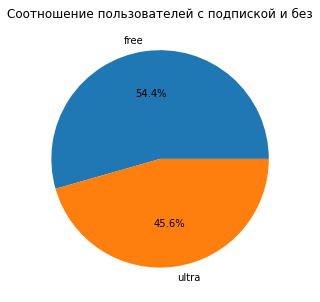

In [17]:
plt.figure(figsize=(8,5))
plt.pie(users_type['count_subscription'], labels=users_type['subscription_type'], autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без')

Процент пользователей с подпиской на 10% процентов меньше, чем без подписки

##### Анализ возраста пользователей

In [18]:
def categorize_age(age):
    try:
        if 20 <= age <= 25:
            return '20-25 лет'
        elif 25 < age <= 30:
            return '26-30 лет'
        elif 25 < age:
            return 'старше 30'
        elif age < 20:
            return 'моложе 20'
    except:
        pass
    
users['age_type'] = users['age'].apply(categorize_age)

users.groupby('age_type')['user_id'].agg(['count'])\
    .sort_values(by = 'count', ascending = False)

,count
age_type,
20-25 лет,689
26-30 лет,498
старше 30,175
моложе 20,172


In [19]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Распределение по возрасту')

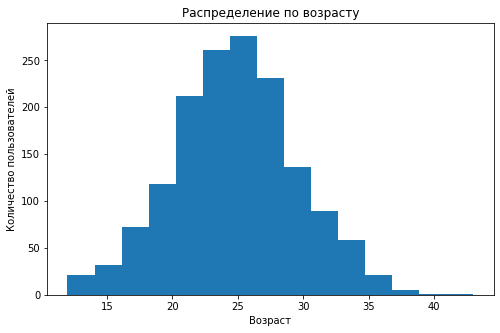

In [20]:
plt.figure(figsize=(8,5))
plt.hist(users['age'], bins=15)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение по возрасту')

In [21]:
users = users.drop(columns = 'age_type', axis = 1)

Основная часть пользователей это молодые люди 20-25 лет, данные по возрасту имеют нормальное распределение со средним значением 24,9. Самому молодому пользователю 12 лет, а самому взрослому -43 года.

##### Анализ длинны одной поездки

In [22]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0.5, 1.0, 'Распределение по расстоянию')

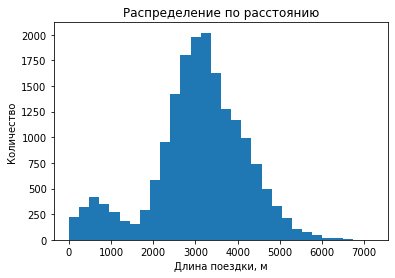

In [23]:
#plt.figure(figsize=(8,5))
plt.hist(rides['distance'], bins=30)
plt.xlabel('Длина поездки, м')
plt.ylabel('Количество')
plt.title('Распределение по расстоянию')

In [24]:
rides.loc[rides['distance']<1000]

,user_id,distance,duration,date,ride_month
2,1,754.159807,6.232113,2021-04-20,4
9,1,748.690645,15.041884,2021-11-22,11
20,2,923.007439,6.914760,2021-08-03,8
47,4,724.559572,11.811399,2021-11-14,11
91,9,979.657684,17.521497,2021-03-08,3
...,...,...,...,...,...
18030,1532,842.097458,8.608989,2021-04-01,4
18031,1532,303.787850,7.792490,2021-05-21,5
18037,1532,662.468186,9.528773,2021-11-18,11
18043,1533,310.488247,10.642389,2021-02-21,2


Распределение длинны поездки имеет нормальное распределение с двумя пиками, маленьким в районе 600м и большим в 3000м. Можно предположить, что маленький пик не является аномальным, т.к время поездки тоже невелико. Вполне возможно такие поездки имеют место быть от дома до станции метро.

##### Анализ продолжительности одной поездки

In [25]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0.5, 1.0, 'Распределение по продолжительности')

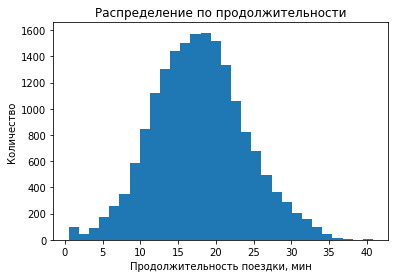

In [26]:
plt.hist(rides['duration'], bins=30)
plt.xlabel('Продолжительность поездки, мин')
plt.ylabel('Количество')
plt.title('Распределение по продолжительности')

Продолжительность поездки имеет нормальное распределение с макс 17.67 мин


    В ходе исследовательского анализа данных выявили следующее. Пользователи зарегистрированы из 8 городов, самое большое количество пользователей самокатов в г. Пятигорске.Частота встречаемости городов распределена практически равномерно. Процент пользователей с подпиской 45.57% от общего количества пользователей, что на 10% меньше чем пользователей без подписки. Основная часть пользователей это молодые люди 20-25 лет, данные по возрасту имеют нормальное распределение со средним значением 24,9.Распределение длинны поездки имеет нормальное распределение с двумя пиками, маленьким в районе 600м и большим в 3000м. Распределение продолжительности поездки тоже имеет нормальное распределение со средним значением около 17,67 мин. 


#### Шаг 4. Объединение данных

##### Объединение данных в один датафрем

In [27]:
data = users.merge(rides, on='user_id', how='left')
data = data.merge(subscriptions, on='subscription_type', how='left')
data.head(15)

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   ride_month         18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


##### Разделение датафрейма по наличию подписки

In [29]:
data_free = data.loc[data['subscription_type']=='free'] #пользователи без подписки
data_ultra = data.loc[data['subscription_type']=='ultra'] # пользователи с подпиской

In [30]:
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [31]:
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,ride_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализация информации

Визуализируем информацию о расстоянии и длинне поездок для пользователей с подписками и нет

Text(0.5, 0, 'Расстояние поездки, м')

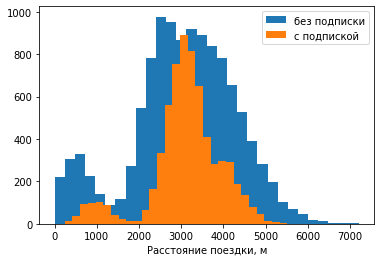

In [32]:
plt.hist(data_free['distance'], bins=30, label='без подписки')
plt.hist(data_ultra['distance'], bins=30, label='с подпиской', stacked=True)
plt.legend()
plt.xlabel("Расстояние поездки, м")

Text(0.5, 0, 'Продолжительность поездки, мин')

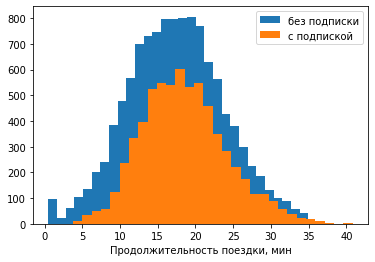

In [33]:
plt.hist(data_free['duration'], bins=30, label='без подписки')
plt.hist(data_ultra['duration'], bins=30, label='с подпиской', stacked=True)
plt.legend()
plt.xlabel("Продолжительность поездки, мин")

Расстояние и продолжительность поездок для пользователей с подписками и без имеет практически одинаковую форму распределения

Объединили даннные в один датафрейм, посмотрили их в разрезе пользователей с подписками и без, убедились что распределение продолжительности и длинны поездок у пользователей и без иммет идентичную форму.

#### Шаг 5. Подсчёт выручки

##### Создание датафрейма с агрегированными данными

In [34]:
data['duration'] = np.ceil(data['duration']) # округлим продолжительность поездки до следующего целого числа
data_agg = data.pivot_table(index=['user_id', 'ride_month'], values=['distance', 'duration'], aggfunc=['count', 'sum'])
data_agg.columns=['count_distance', 'count_duration', 'sum_distance', 'sum_duration'] #создание нового датафрейма
data_agg = data_agg.drop(columns = 'count_duration', axis = 1) #удалим лишний столбец
data_agg = data_agg.reset_index() #зададим новые индексы
data_agg

,user_id,ride_month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42.0
1,1,4,1,754.159807,7.0
2,1,8,2,6723.470560,46.0
3,1,10,2,5809.911100,32.0
4,1,11,3,7003.499363,56.0
...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0
11327,1534,8,2,7622.453034,48.0
11328,1534,9,1,4928.173852,23.0
11329,1534,11,4,13350.015305,78.0


Создали датафрейм с количеством, длинной и продолжительностью поездок, сгруппированных по пользователям помесячно

##### Расчет помесячной выручки

In [35]:
data_agg = data_agg.merge(users, on='user_id', how='left') #добавим данные о пользователях
data_agg = data_agg.merge(subscriptions, on='subscription_type', how='left') #добавим данные о подписках
data_agg['revenue'] = data_agg['start_ride_price']*data_agg['count_distance'] + data_agg[
    'minute_price']*data_agg['sum_duration'] + data_agg['subscription_fee'] #рассчитаем выручку помесячно для каждого пользователя
data_agg

,user_id,ride_month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,Альберт,25,Краснодар,free,8,50,0,308.0
11327,1534,8,2,7622.453034,48.0,Альберт,25,Краснодар,free,8,50,0,484.0
11328,1534,9,1,4928.173852,23.0,Альберт,25,Краснодар,free,8,50,0,234.0
11329,1534,11,4,13350.015305,78.0,Альберт,25,Краснодар,free,8,50,0,824.0


Рассчитали выручку по месячно для каждого пользователя. 

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

В данном случае нулевая гипотеза: средняя продолжительность поездки пользователей с подпиской = ссредняя продолжительность поездки пользователей с подпиской. 
Альтернативная гипотеза: средняя продолжительность поездки пользователей с подпиской больше средней продолжительность поездки пользователей с подпиской

In [36]:
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Вывод: среднее время поездок у пользователей с подпиской больше, чем у пользователей без нее.

##### Можно ли сказать что среднее расстояние которое проезжают пользователи за одну поездку не превышает 3130 м?

Нулевая гипотеза: среднее расстояние которое проезжают пользователи с подпиской за одну поездку равно 3130 м. 
Альтернативная гипотеза: среднее расстояние которое проезжают пользователи с подпиской за одну поездку больше 3130 м

In [37]:
alpha = 0.05 # уровень статистической значимости
distance_norm = 3130
results = st.ttest_1samp(
    data_ultra['distance'], 
    distance_norm,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Гипотеза, что среднее расстояние которое проезжают пользователи за одну поездку превышает 3130 м не подтвердилась.

##### Будет ли помесячная выручка от пользователей с подпиской выше чем от пользователей без нее?

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна выручке от пользователей без нее. 
Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше, чем от пользователей без нее.

In [38]:
data_agg_free = data_agg.loc[data_agg['subscription_type']=='free']
data_agg_ultra = data_agg.loc[data_agg['subscription_type']=='ultra']

alpha = 0.05
# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(data_agg_ultra['revenue'], data_agg_free['revenue'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод: помесячная выручка поездок у пользователей с подпиской больше, чем у пользователей без нее.

##### Какой тест необходим для проверки гипотезы о том что после обновления мобильного приложения количество обращений в тех поддержку снизилось?

Имеем файл с данными для каждого пользователя - количество обращений до обновления и после. Т.е. это две зависимые выборки, для проверки такой гипотезы следует использовать метод scipy.stats.ttest_rel, указав alternative='less', для проверки правосторонней выборки.

#### Шаг 7. Распределения

##### 
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

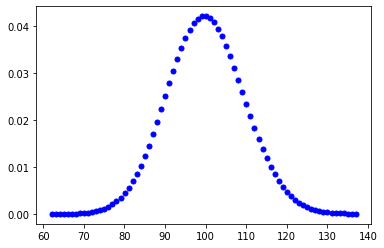

In [39]:
n = 1000 # параметры биномиального распределения
p = 0.1 

mu = n*p
sigma = np.sqrt(n * p * (1 - p))

#возьмем интервал распределения 
#от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
arange = np.arange(mu-4*sigma, mu+4*sigma, 1) 

plt.plot(arange, binom.pmf(arange, n, p), 'bo', ms=5)
plt.show()

In [40]:
n = 1000 # параметры биномиального распределения
p = 0.1 

mu = n*p # параметры нормального распределения
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) # задайте нормальное распределение

result = distr.ppf(0.05) 
result

84.39554836373327

1000 промокодов дают 84 подписки с вероятностью 95%

In [41]:
p = 0.1 
# переберем целые числа в интервале от 1000 до 1300, 
# чтобы найти количество промокодов при котором минимум 100 человек с вероятностью 95% оформят подписку
for n in range (1000, 1300):
    mu = n*p 
    sigma = sqrt(n * p * (1 - p)) 
    distr = st.norm(mu, sigma) 
    if distr.ppf(0.05)>100:
        print('Число промокодов равно', n)
        break
    


Число промокодов равно 1169


Чтобы вероятность не выполнить план была примерно 5%, необходимо отправить 1169 промокодов. 

##### 
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [42]:
n = 1000000 # параметры биномиального распределения
p = 0.4 

# параметры нормального распределения
mu = n*p 
sigma = sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma) # зададим нормальное распределение

result = distr.cdf(399500) # посчитаем вероятность 
print('Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей', result.round(2)*100, '%')

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 15.0 %


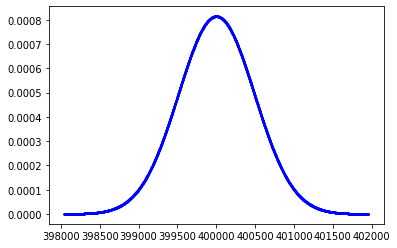

In [43]:

n = 1000000 # параметры биномиального распределения
p = 0.4 

mu = n*p
sigma = np.sqrt(n * p * (1 - p))

#возьмем интервал распределения 
#от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
arange = np.arange(mu-4*sigma, mu+4*sigma, 1)

plt.plot(arange, binom.pmf(arange, n, p), 'bo', ms=1)
plt.show()


    Был проведен анализ популярного сервиса аренды самокатов GoFast, по данным о некоторых пользователях из нескольких городов, а также об их поездках и оформленных подписках. 
    Сначала была проведена предобработка данных - проверка на пустые значения и дубликаты в датафреймах.
        Далее проведен исследовательский анализ данных о пользователях и их поездках, а также о наличии подписки у пользователей. Даннные о пользователях даны из 8 городов, самое большое количество пользователей самокатов в г. Пятигорске. Процент пользователей с подпиской 45.57% от общего количества пользователей. Основная часть пользователей это молодые люди 20-25 лет, данные по возрасту имеют нормальное распределение со средним значением 24,9.Распределение длинны поездки имеет нормальное распределение с двумя пиками, маленьким в районе 600м и большим в 3000м. Распределение продолжительности поездки тоже имеет нормальное распределение со средним значением около 17 мин. Расстояние и продолжительность поездок для пользователей с подписками и без имеет практически одинаковую форму распределения.
    Рассчитали выручку помесячно для каждого пользователя, для этого провели обьединение датафреймов и составили датафрейм с агрегированными данными о продолжительности и расстоянии поездок для каждого пользователя по месяцам.
    Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, для этого необходимо проверит несколько гипотез:
    1. Тратят ли пользователи с подпиской больше времени на поездки? Гипотеза подтвердилась, пользователи с подпиской имеют продолжительность поездок больше чем пользователи без подписки.
    2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Гипотеза подтвердилась, длинна поездок у пользователей с подпиской не превышает 3130 м. 
    3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? Гипотеза подтвердилась - помесячная выручка поездок у пользователей с подпиской больше, чем у пользователей без нее.
    Можно сделать вывод о том что пользователи с подпиской "выгоднее" с точки зрения бизнеса. Необходимо проводить больше акций, сделать подписку более привлекательной, предлагать пользователям без подписки ее оформить.
    Дополнительно было решено две задачи на биноминальное распределение.
